In [1]:
import os,json,random
from collections import defaultdict
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from cycler import cycler

In [2]:
def createConceptDict(allConcepts,json_data):
    treshold = 0.8
    # Create a dict of lists. For each concept we have a dict of the size duration of the video
    ## 0 where the concept is not present and 1 where is present
    conceptDict=defaultdict(list,{k:[] for k in allConcepts})

    for key in conceptDict.keys():
        for frame in json_data:
            found = False
            for concept in frame['data']['concepts']:
                if key == concept['name'] and concept['value'] > treshold:
                    conceptDict[key].append(1)
                    found = True
                    break
            if not found:
                conceptDict[key].append(0)
    return conceptDict

In [3]:
# Create a set with every concept name
def createAllConcepts(json_data):
    allConcepts = set()
    for frame in json_data:
        for concept in frame['data']['concepts']:
            if concept['name'] not in allConcepts:
                allConcepts.add(concept['name']) 
            #print('%s %f' % (concept['name'], concept['value']))
    return allConcepts

In [4]:
def findOcorrences(myList):
    i = 0
    timeTuplesList = []
    while i < len(myList):
        n = myList[i]
        if n == 1:
            startTime = i
            duration = 1
            while i < len(myList) - 1 and myList[i] == myList[i + 1]:
                duration = duration + 1
                i = i + 1
            timeTuplesList.append((startTime, duration))
        i = i + 1
    return timeTuplesList

In [5]:
def mergeConcepts(*lists):
    # create list of zeros with the size of the first list argument
    outList = [0] * len(lists[0])
    for elem in lists:
        outList = [a or b for a, b in zip(outList, elem)]
    return outList

In [6]:
def hashColorFromName(name):
    numb = 0
    for ch in name:
        numb += ord(ch)
    return numb

In [37]:
def plotConcepts(filename,detectedConcepts,predictions):
    
    fig, gnt = plt.subplots(figsize=(15, 2)) 

    # Setting Y-axis limits 
    gnt.set_ylim(0, len(detectedConcepts)*10) 

    # Setting X-axis limits 
    videoSize = len(conceptDict[random.choice(list(conceptDict))])
    gnt.set_xlim(0, videoSize)
    tickList = list(range(0, videoSize, 2))
    tickList.append(videoSize)
   
    plt.xticks(tickList)

    #gnt.xaxis.set_major_locator(ticker.MultipleLocator(5))


    # Setting labels for x-axis and y-axis 
    fig.suptitle(os.path.splitext(filename)[0], y=1.2,fontsize=15)
    gnt.set_xlabel('Video Seconds') 
    gnt.set_ylabel('Tags') 

    # Setting ticks on y-axis 
    
    gnt.set_yticks([x*10 for x in range(0,len(detectedConcepts))])
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(detectedConcepts) 
    # aligning ticks
    for tick in gnt.yaxis.get_majorticklabels():
        tick.set_verticalalignment('bottom')


    # Setting graph color attribute 
    gnt.grid(True) 
    cmap = plt.cm.get_cmap('hsv', len(detectedConcepts)+1)

    inc = 0
    i = 0
    for concept in detectedConcepts:
        gnt.broken_barh(predictions[concept], (inc, 10),facecolors =(cmap(i)))
        inc+=10
        i+=1

    plt.show()

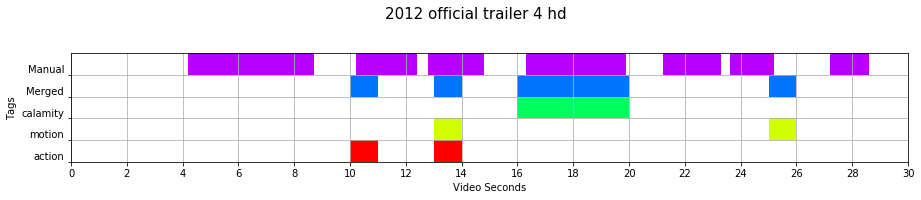

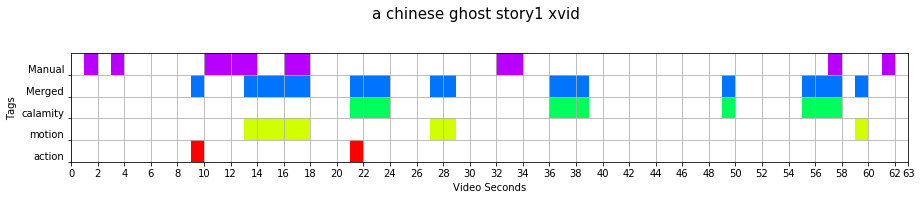

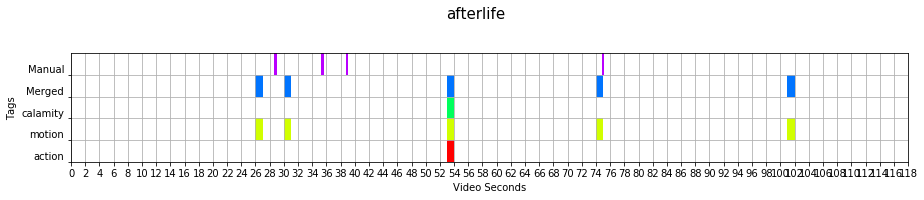

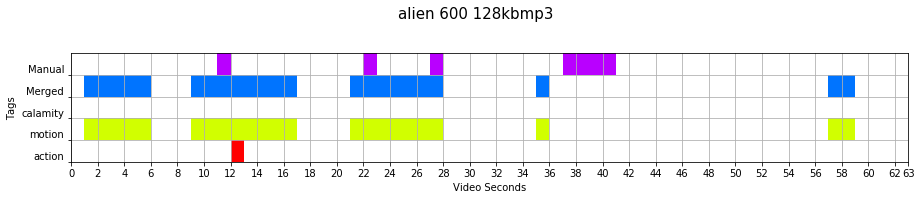

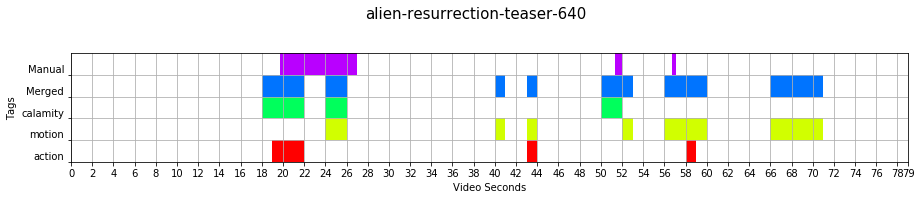

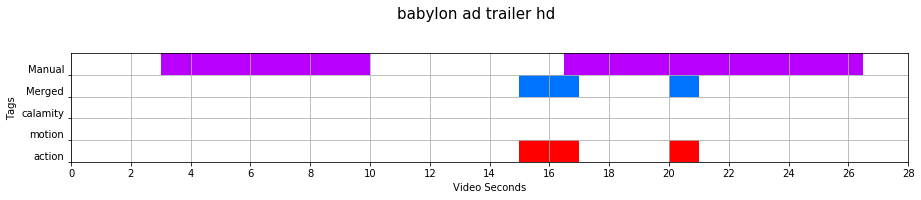

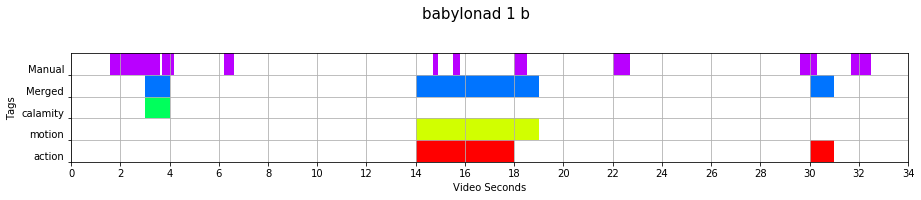

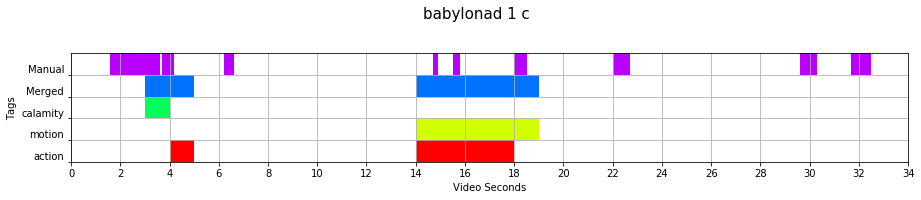

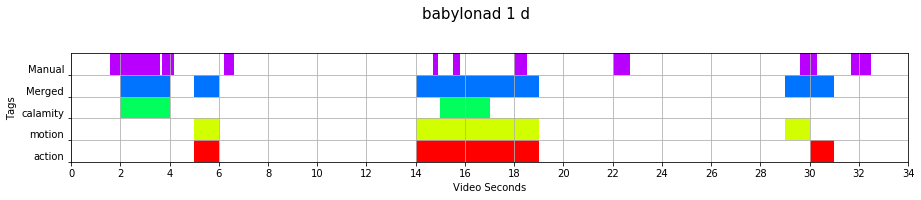

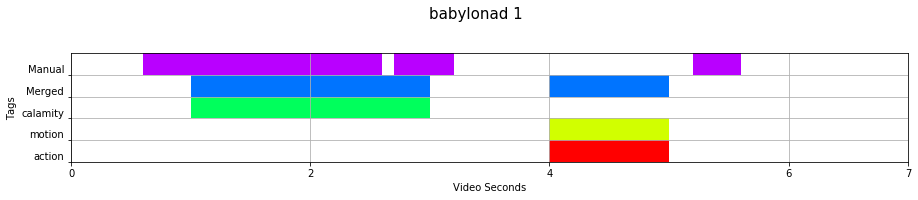

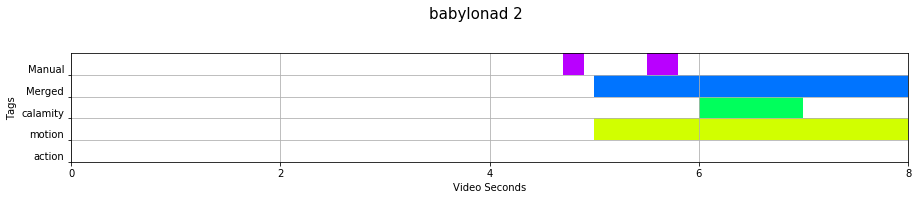

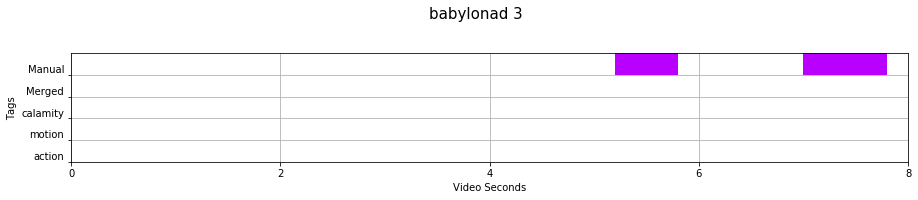

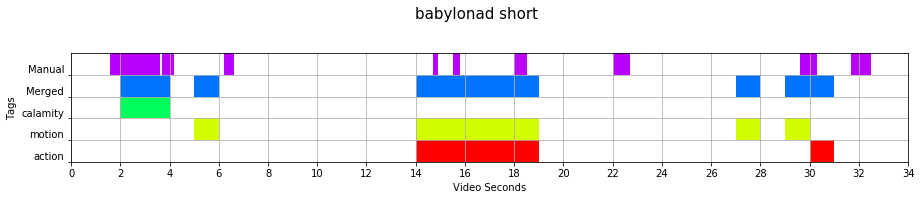

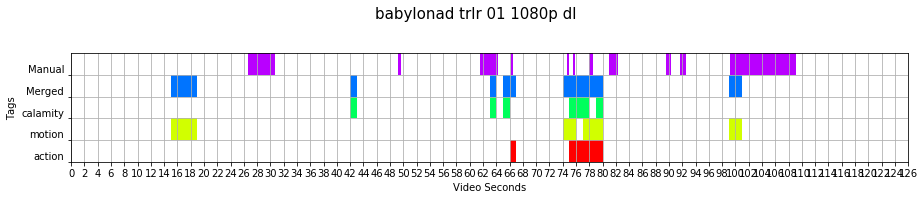

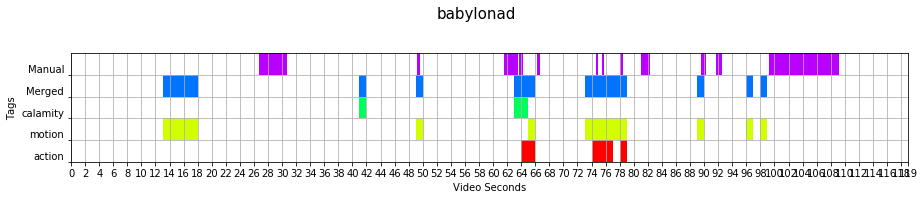

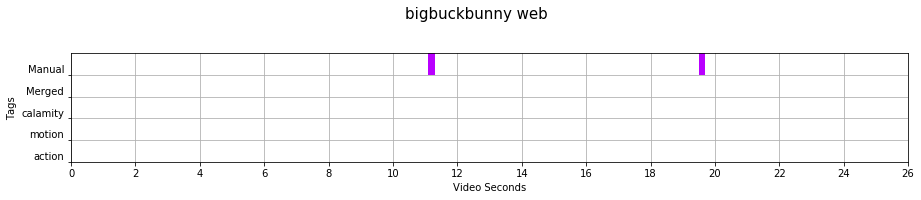

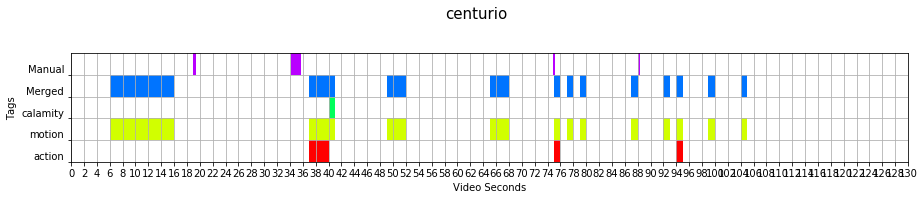

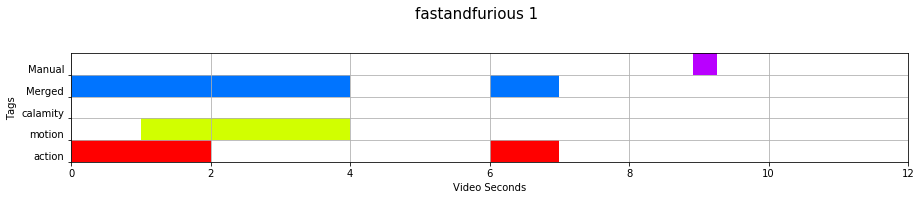

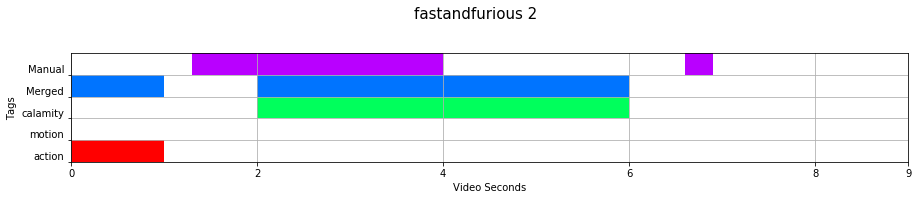

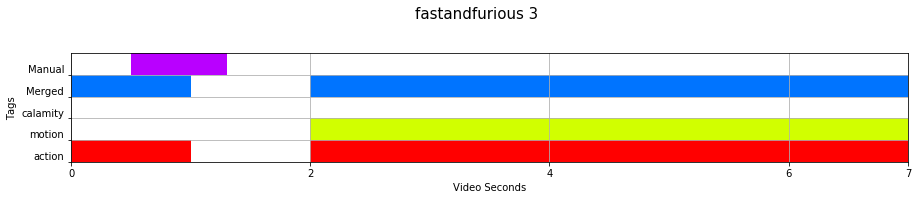

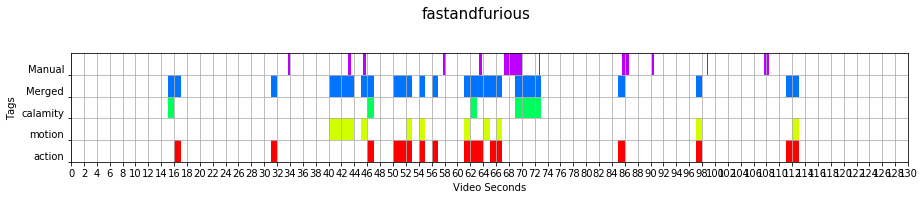

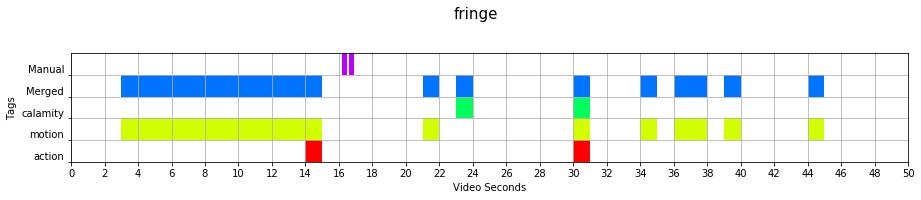

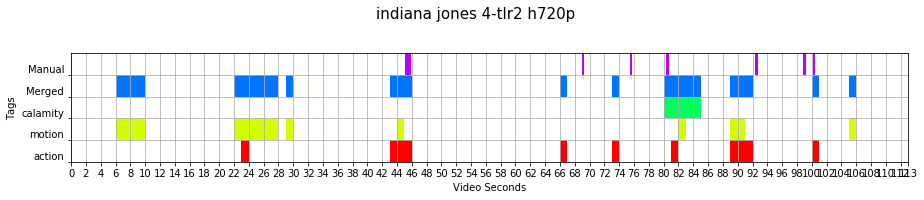

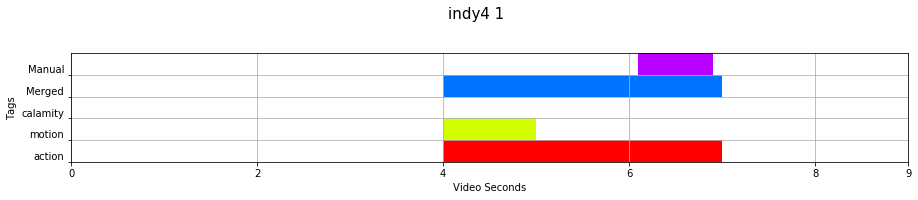

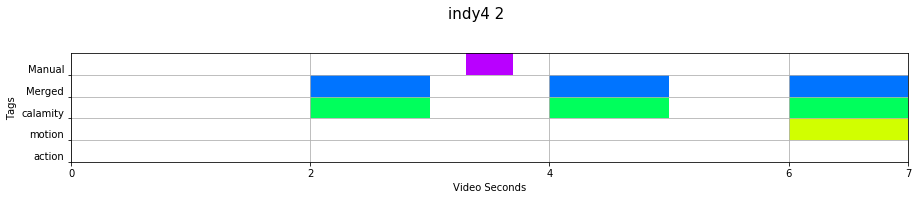

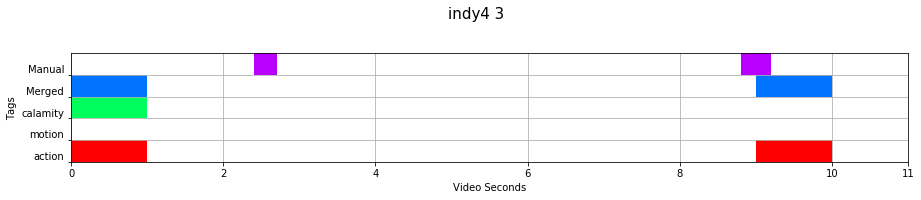

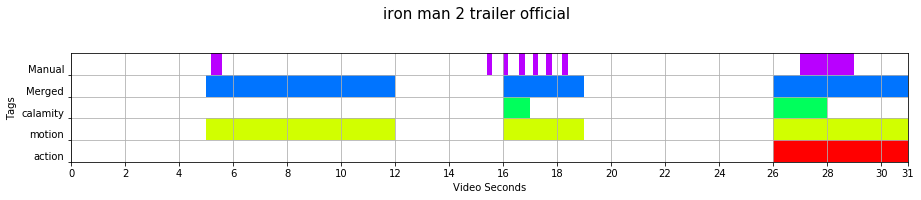

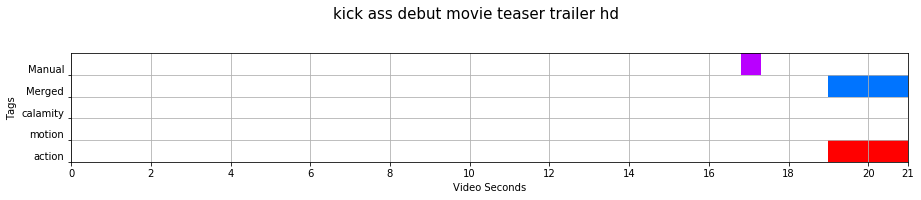

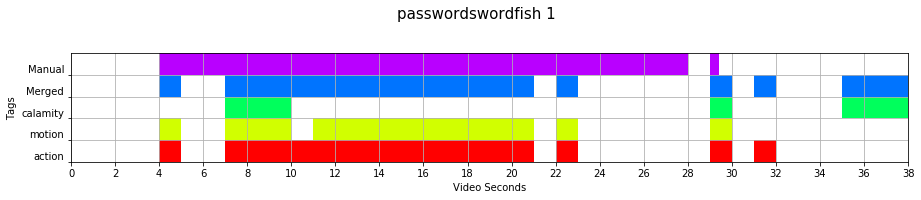

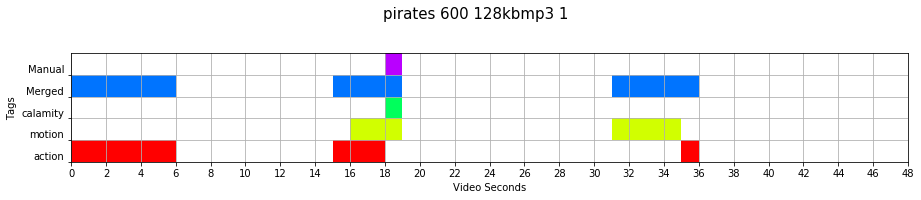

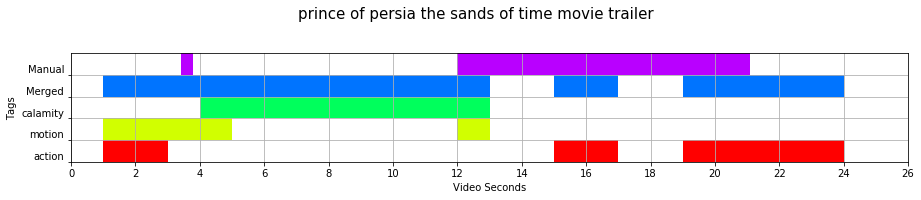

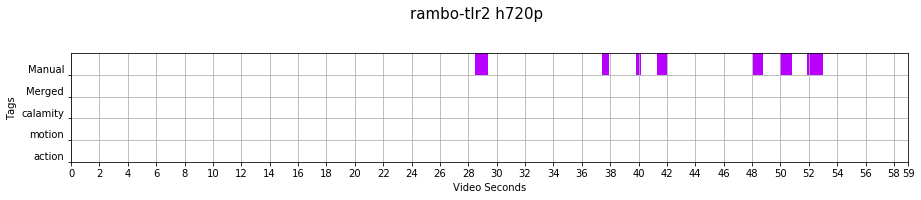

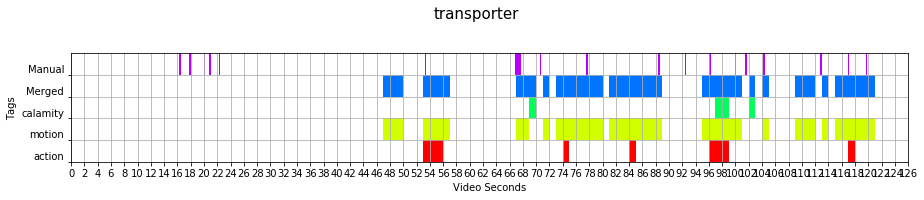

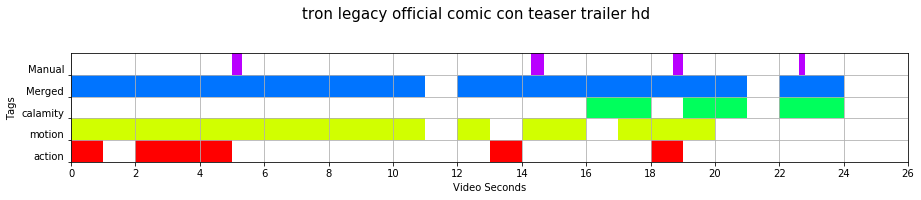

In [39]:
path = 'data/recognition/'

for filename in os.listdir(path):
    #filename = 'Pirates 600 128Kbmp3 1.json'
    with open(path+filename) as json_file:
        json_data = json.load(json_file)

    with open('data/markupSEM.json') as json_file:
        markupSEM = json.load(json_file)

    allConcepts = createAllConcepts(json_data)

    conceptDict = createConceptDict(allConcepts,json_data)
    
    
    detectedConcepts = ['action', 'motion', 'calamity']

    ## insert predictions
    predictions = {}
    for concept in detectedConcepts:
        predictions[concept] =(findOcorrences(conceptDict[concept]))

    ## add merged predictions
    #create merged prediction : or's the 1's in each list into a single list
    mergedPrediction = mergeConcepts(*filter(None, [conceptDict[x] for x in detectedConcepts]))
    # Explanation:
    # [conceptDict[x] for x in detectedConcepts]  returns lists that are in detectedConcepts (i.e the lists  selected to show)
    # filter removes the lists that could be empty (i.e. the concept was  not found)
    # * unpacks the list into the arguments (which are also lists, but whatever...)
    # mergeConcepts merges the 1's of all the lists into a single  

    ## add merged markup
    detectedConcepts.append('Merged')
    predictions['Merged'] = (findOcorrences(mergedPrediction)) 


    ## add manual markup (ground truth) 
    detectedConcepts.append('Manual')
    predictions['Manual'] = []
    for markup in markupSEM[os.path.splitext(filename)[0]]['VibrationType']:
        # converting time of end into duration of effects
        markup[1] = markup[1] - markup[0]
        predictions['Manual'].append(tuple(markup))   
    
    plotConcepts(filename,detectedConcepts,predictions)


In [ ]:
##TODO: Show how many seconds we hit and show how many seconds we miss..

## basically a XOR of Merged and ground truth markup